In [20]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [21]:
# Load and preprocess data
file_path = '0703_total.xlsx'
dfs = pd.read_excel(file_path, sheet_name=None)

def preprocess_data(df):
    if 'date' not in df.columns:
        raise KeyError("Missing 'date' column in the dataset")
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    y = df.iloc[:, 0].astype('category').cat.codes
    X = df.iloc[:, 1:]
    return X, y


In [22]:
def clean_data(X, y):
    # Replace infinities with NaNs
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    # Drop rows with NaNs
    valid_indices = ~X.isnull().any(axis=1)
    X = X[valid_indices]
    y = y[valid_indices]
    return X, y


In [25]:
# Prepare data
data_splits = {}
for keyword, df in dfs.items():
    try:
        X, y = preprocess_data(df)
        
        # Check for and remove invalid labels
        valid_indices = y >= 0
        X = X[valid_indices]
        y = y[valid_indices]

        # Clean data
        X, y = clean_data(X, y)

        # Ensure consistent lengths
        if len(X) != len(y):
            raise ValueError(f"Inconsistent data lengths for {keyword}: {len(X)} features, {len(y)} labels")

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Check for NaNs and Infinities
        if np.any(np.isnan(X_train_scaled)) or np.any(np.isinf(X_train_scaled)):
            raise ValueError(f"NaNs or Infinities detected in X_train for {keyword}")
        if np.any(np.isnan(X_test_scaled)) or np.any(np.isinf(X_test_scaled)):
            raise ValueError(f"NaNs or Infinities detected in X_test for {keyword}")
        
        data_splits[keyword] = {
            'X_train': X_train_scaled,
            'X_test': X_test_scaled,
            'y_train': y_train,
            'y_test': y_test
        }
    except KeyError as e:
        print(f"Skipping {keyword} due to missing 'date' column")
    except ValueError as e:
        print(f"Skipping {keyword} due to data issues: {e}")

# Define the model
def create_model(input_dim, dropout_rate=0.5, l1_reg=0.001, l2_reg=0.001, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softmax'))  # Assuming 3 classes: S_buy, buy, sell
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train and evaluate the model for each keyword
results = {}
for keyword, data_split in data_splits.items():
    X_train = data_split['X_train']
    X_test = data_split['X_test']
    y_train = data_split['y_train']
    y_test = data_split['y_test']
    
    input_dim = X_train.shape[1]
    model = create_model(input_dim)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
    
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    results[keyword] = test_accuracy
    
    model.save(f'plk_folder_05/{keyword}_model.keras')
    print(f'{keyword} model saved with test accuracy: {test_accuracy}')

# Print results
for keyword, accuracy in results.items():
    print(f"{keyword}: Test Accuracy = {accuracy:.4f}")

Skipping auto due to missing 'date' column
Skipping construct due to missing 'date' column
Skipping capital_market due to missing 'date' column
Skipping chemicals due to missing 'date' column
Skipping equipment due to missing 'date' column
Skipping transport due to missing 'date' column
Skipping semi due to missing 'date' column
Skipping bank due to missing 'date' column
Skipping steel due to missing 'date' column
Skipping telecom due to missing 'date' column
Skipping staples due to missing 'date' column
Skipping discretionary due to missing 'date' column
Skipping kospi due to missing 'date' column


In [28]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load and preprocess data
file_path = '0703_total.xlsx'
dfs = pd.read_excel(file_path, sheet_name=None)

def preprocess_data(df):
    if 'date' not in df.columns:
        raise KeyError("Missing 'date' column in the dataset")
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    y = df.iloc[:, 0].astype('category').cat.codes
    X = df.iloc[:, 1:]
    return X, y

def clean_data(X, y):
    # Replace infinities with NaNs
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    # Drop rows with NaNs
    valid_indices = ~X.isnull().any(axis=1)
    X = X[valid_indices]
    y = y[valid_indices]
    return X, y

# Prepare data
data_splits = {}
for keyword, df in dfs.items():
    try:
        X, y = preprocess_data(df)
        
        # Check for and remove invalid labels
        valid_indices = y >= 0
        X = X[valid_indices]
        y = y[valid_indices]

        # Clean data
        X, y = clean_data(X, y)

        # Ensure consistent lengths
        if len(X) != len(y):
            raise ValueError(f"Inconsistent data lengths for {keyword}: {len(X)} features, {len(y)} labels")

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Check for NaNs and Infinities
        if np.any(np.isnan(X_train_scaled)) or np.any(np.isinf(X_train_scaled)):
            raise ValueError(f"NaNs or Infinities detected in X_train for {keyword}")
        if np.any(np.isnan(X_test_scaled)) or np.any(np.isinf(X_test_scaled)):
            raise ValueError(f"NaNs or Infinities detected in X_test for {keyword}")
        
        data_splits[keyword] = {
            'X_train': X_train_scaled,
            'X_test': X_test_scaled,
            'y_train': y_train,
            'y_test': y_test
        }
    except KeyError as e:
        print(f"Skipping {keyword} due to missing 'date' column")
    except ValueError as e:
        print(f"Skipping {keyword} due to data issues: {e}")

# Define the model
def create_model(input_dim, dropout_rate=0.5, l1_reg=0.001, l2_reg=0.001, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softmax'))  # Assuming 3 classes: S_buy, buy, sell
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train and evaluate the model for each keyword
results = {}
for keyword, data_split in data_splits.items():
    X_train = data_split['X_train']
    X_test = data_split['X_test']
    y_train = data_split['y_train']
    y_test = data_split['y_test']
    
    input_dim = X_train.shape[1]
    model = create_model(input_dim)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
    
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    results[keyword] = test_accuracy
    
    model.save(f'plk_folder_05/{keyword}_model.keras')
    print(f'{keyword} model saved with test accuracy: {test_accuracy}')

# Print results
for keyword, accuracy in results.items():
    print(f"{keyword}: Test Accuracy = {accuracy:.4f}")


Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3172 - loss: 4.1666 - val_accuracy: 0.4694 - val_loss: 3.1607
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3954 - loss: 3.6593 - val_accuracy: 0.5621 - val_loss: 3.0635
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4085 - loss: 3.5493 - val_accuracy: 0.5779 - val_loss: 2.9833
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4193 - loss: 3.3659 - val_accuracy: 0.5917 - val_loss: 2.9263
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4443 - loss: 3.2099 - val_accuracy: 0.5937 - val_loss: 2.8712
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4870 - loss: 3.0744 - val_accuracy: 0.5917 - val_loss: 2.8264
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4785 - loss: 3.0661 - val_accuracy: 0.5957 - val_loss: 2.7731
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4869 - loss: 2.9490 - val_accuracy: 0.6016 - v

In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from joblib import dump, load
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Ensure the results directory exists
if not os.path.exists('plk_folder_05'):
    os.makedirs('plk_folder_05')

# Load and preprocess data
keywords = ["auto", "construct", "capital_market", "chemicals", "equipment",
            "transport", "semi", "bank", "steel", "telecom", "staples", "discretionary", "kospi"]

dfs = {}
column_names_per_keyword = {}

for keyword in keywords:
    dfs[keyword] = pd.read_excel('0703_total.xlsx', sheet_name=keyword, header=0, index_col=0)
    column_names_per_keyword[keyword] = dfs[keyword].columns.tolist()

# Convert index to string dates
for keyword, df in dfs.items():
    df.index = pd.to_datetime(df.index)
    df.index = df.index.strftime('%Y-%m-%d')

# Prepare data splits
data_splits = {}
last_rows = {}

for keyword, df in dfs.items():
    last_row = df.iloc[-1]
    last_rows[keyword] = last_row
    
    df_dropna = df.dropna()
    
    if df_dropna.empty:
        print(f"Error: Dataframe for {keyword} is empty.")
        continue

    y_keyword = df_dropna[keyword]
    X_keyword = df_dropna.drop(columns=[keyword])

    X_train, X_test, y_train, y_test = train_test_split(X_keyword, y_keyword, test_size=0.2, random_state=0)
    
    normalizer = StandardScaler()
    X_train_normalized = normalizer.fit_transform(X_train)
    X_test_normalized = normalizer.transform(X_test)

    data_splits[keyword] = {
        'X_train': X_train_normalized,
        'X_test': X_test_normalized,
        'y_train': y_train,
        'y_test': y_test
    }

# Find best model parameters
best_estimators_per_keyword = {}
best_depths_per_keyword = {}

for keyword, data_split in data_splits.items():
    X_train = data_split['X_train']
    y_train = data_split['y_train']
    
    cv_scores = []
    cv_scores_depth = []

    for i in tqdm(range(20)):
        rfc = RandomForestClassifier(n_estimators=i+1, max_leaf_nodes=300, n_jobs=-1, random_state=0)
        score = cross_val_score(rfc, X_train, y_train, cv=10, scoring='accuracy').mean()
        cv_scores.append(score)

    best_estimator = cv_scores.index(max(cv_scores)) + 1
    best_estimators_per_keyword[keyword] = best_estimator
    
    for i in tqdm(range(20)):
        rfc = RandomForestClassifier(n_estimators=best_estimator, max_depth=i+1, max_leaf_nodes=300, n_jobs=-1, random_state=0)
        score = cross_val_score(rfc, X_train, y_train, cv=10, scoring='accuracy').mean()
        cv_scores_depth.append(score)

    best_depth = cv_scores_depth.index(max(cv_scores_depth)) + 1
    best_depths_per_keyword[keyword] = best_depth

# Train and save the best models
for keyword, data_split in data_splits.items():
    X_train = data_split['X_train']
    y_train = data_split['y_train']

    rfc = RandomForestClassifier(n_estimators=best_estimators_per_keyword[keyword], 
                                 max_depth=best_depths_per_keyword[keyword], 
                                 max_leaf_nodes=300,
                                 n_jobs=-1,
                                 random_state=0)

    rfc.fit(X_train, y_train)
    filename = f"plk_folder_05/{keyword}_model.pkl"
    dump(rfc, filename)
    print(f"Model for {keyword} keyword saved as {filename}")

print("\n< AI model: save >")

# Load models
loaded_models = {}

for keyword in keywords:
    filename = f"plk_folder_05/{keyword}_model.pkl"
    if os.path.exists(filename):
        loaded_models[keyword] = load(filename)
        print(f"Model for {keyword} keyword loaded from {filename}")
    else:
        print(f"Model file for {keyword} keyword does not exist: {filename}")

print("\n< AI model: load >")

# Predict probabilities for the last rows
probabilities = {}
for keyword, model in loaded_models.items():
    X_test_last_row_keyword = last_rows[keyword].values.reshape(1, -1)
    X_test_last_row_keyword = X_test_last_row_keyword[:, 1:]
    prob_current = model.predict_proba(X_test_last_row_keyword)
    probabilities[keyword] = {'S_buy': prob_current[0][0], 'buy': prob_current[0][1], 'sell': prob_current[0][2]}

# Print results
for keyword, probs in probabilities.items():
    print(keyword)
    for action, prob in probs.items():
        print(f'{action}: {prob:.4f}')
    print()

# Plot results
num_keywords = len(probabilities)
num_rows = (num_keywords + 2) // 3
num_cols = min(num_keywords, 3)
plt.figure(figsize=(6 * num_cols, 4 * num_rows))

for i, (keyword, probs) in enumerate(probabilities.items(), start=1):
    plt.subplot(num_rows, num_cols, i)
    plt.bar(probs.keys(), probs.values(), color=['skyblue', 'salmon', 'lightgreen'])
    plt.title(f'{keyword} Keyword')
    plt.xlabel('Action')
    plt.ylabel('Probability')
    plt.ylim(0, 1)
    for j, prob in enumerate(probs.values()):
        plt.text(j, prob, f'{prob:.4f}', ha='center', va='bottom')
        print(f'{keyword}')
        for action, prob in probs.items():
            print(f'{action}: {prob:.4f}')
        print()
plt.tight_layout()
plt.show()


100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


Model for auto keyword saved as plk_folder_05/auto_model.pkl
Model for construct keyword saved as plk_folder_05/construct_model.pkl
Model for capital_market keyword saved as plk_folder_05/capital_market_model.pkl
Model for chemicals keyword saved as plk_folder_05/chemicals_model.pkl
Model for equipment keyword saved as plk_folder_05/equipment_model.pkl
Model for transport keyword saved as plk_folder_05/transport_model.pkl
Model for semi keyword saved as plk_folder_05/semi_model.pkl
Model for bank keyword saved as plk_folder_05/bank_model.pkl
Model for steel keyword saved as plk_folder_05/steel_model.pkl
Model for telecom keyword saved as plk_folder_05/telecom_model.pkl
Model for staples keyword saved as plk_folder_05/staples_model.pkl
Model for discretionary keyword saved as plk_folder_05/discretionary_model.pkl
Model for kospi keyword saved as plk_folder_05/kospi_model.pkl

< AI model: save >
Model file for auto keyword does not exist: plk_folder_05_new/auto_model.pkl
Model file for c

<Figure size 0x0 with 0 Axes>

Model for auto keyword loaded from plk_folder_05/auto_model.pkl
Model for construct keyword loaded from plk_folder_05/construct_model.pkl
Model for capital_market keyword loaded from plk_folder_05/capital_market_model.pkl
Model for chemicals keyword loaded from plk_folder_05/chemicals_model.pkl
Model for equipment keyword loaded from plk_folder_05/equipment_model.pkl
Model for transport keyword loaded from plk_folder_05/transport_model.pkl
Model for semi keyword loaded from plk_folder_05/semi_model.pkl
Model for bank keyword loaded from plk_folder_05/bank_model.pkl
Model for steel keyword loaded from plk_folder_05/steel_model.pkl
Model for telecom keyword loaded from plk_folder_05/telecom_model.pkl
Model for staples keyword loaded from plk_folder_05/staples_model.pkl
Model for discretionary keyword loaded from plk_folder_05/discretionary_model.pkl
Model for kospi keyword loaded from plk_folder_05/kospi_model.pkl

< AI model: load >
auto
S_buy: 0.1065
buy: 0.2130
sell: 0.6804

construct

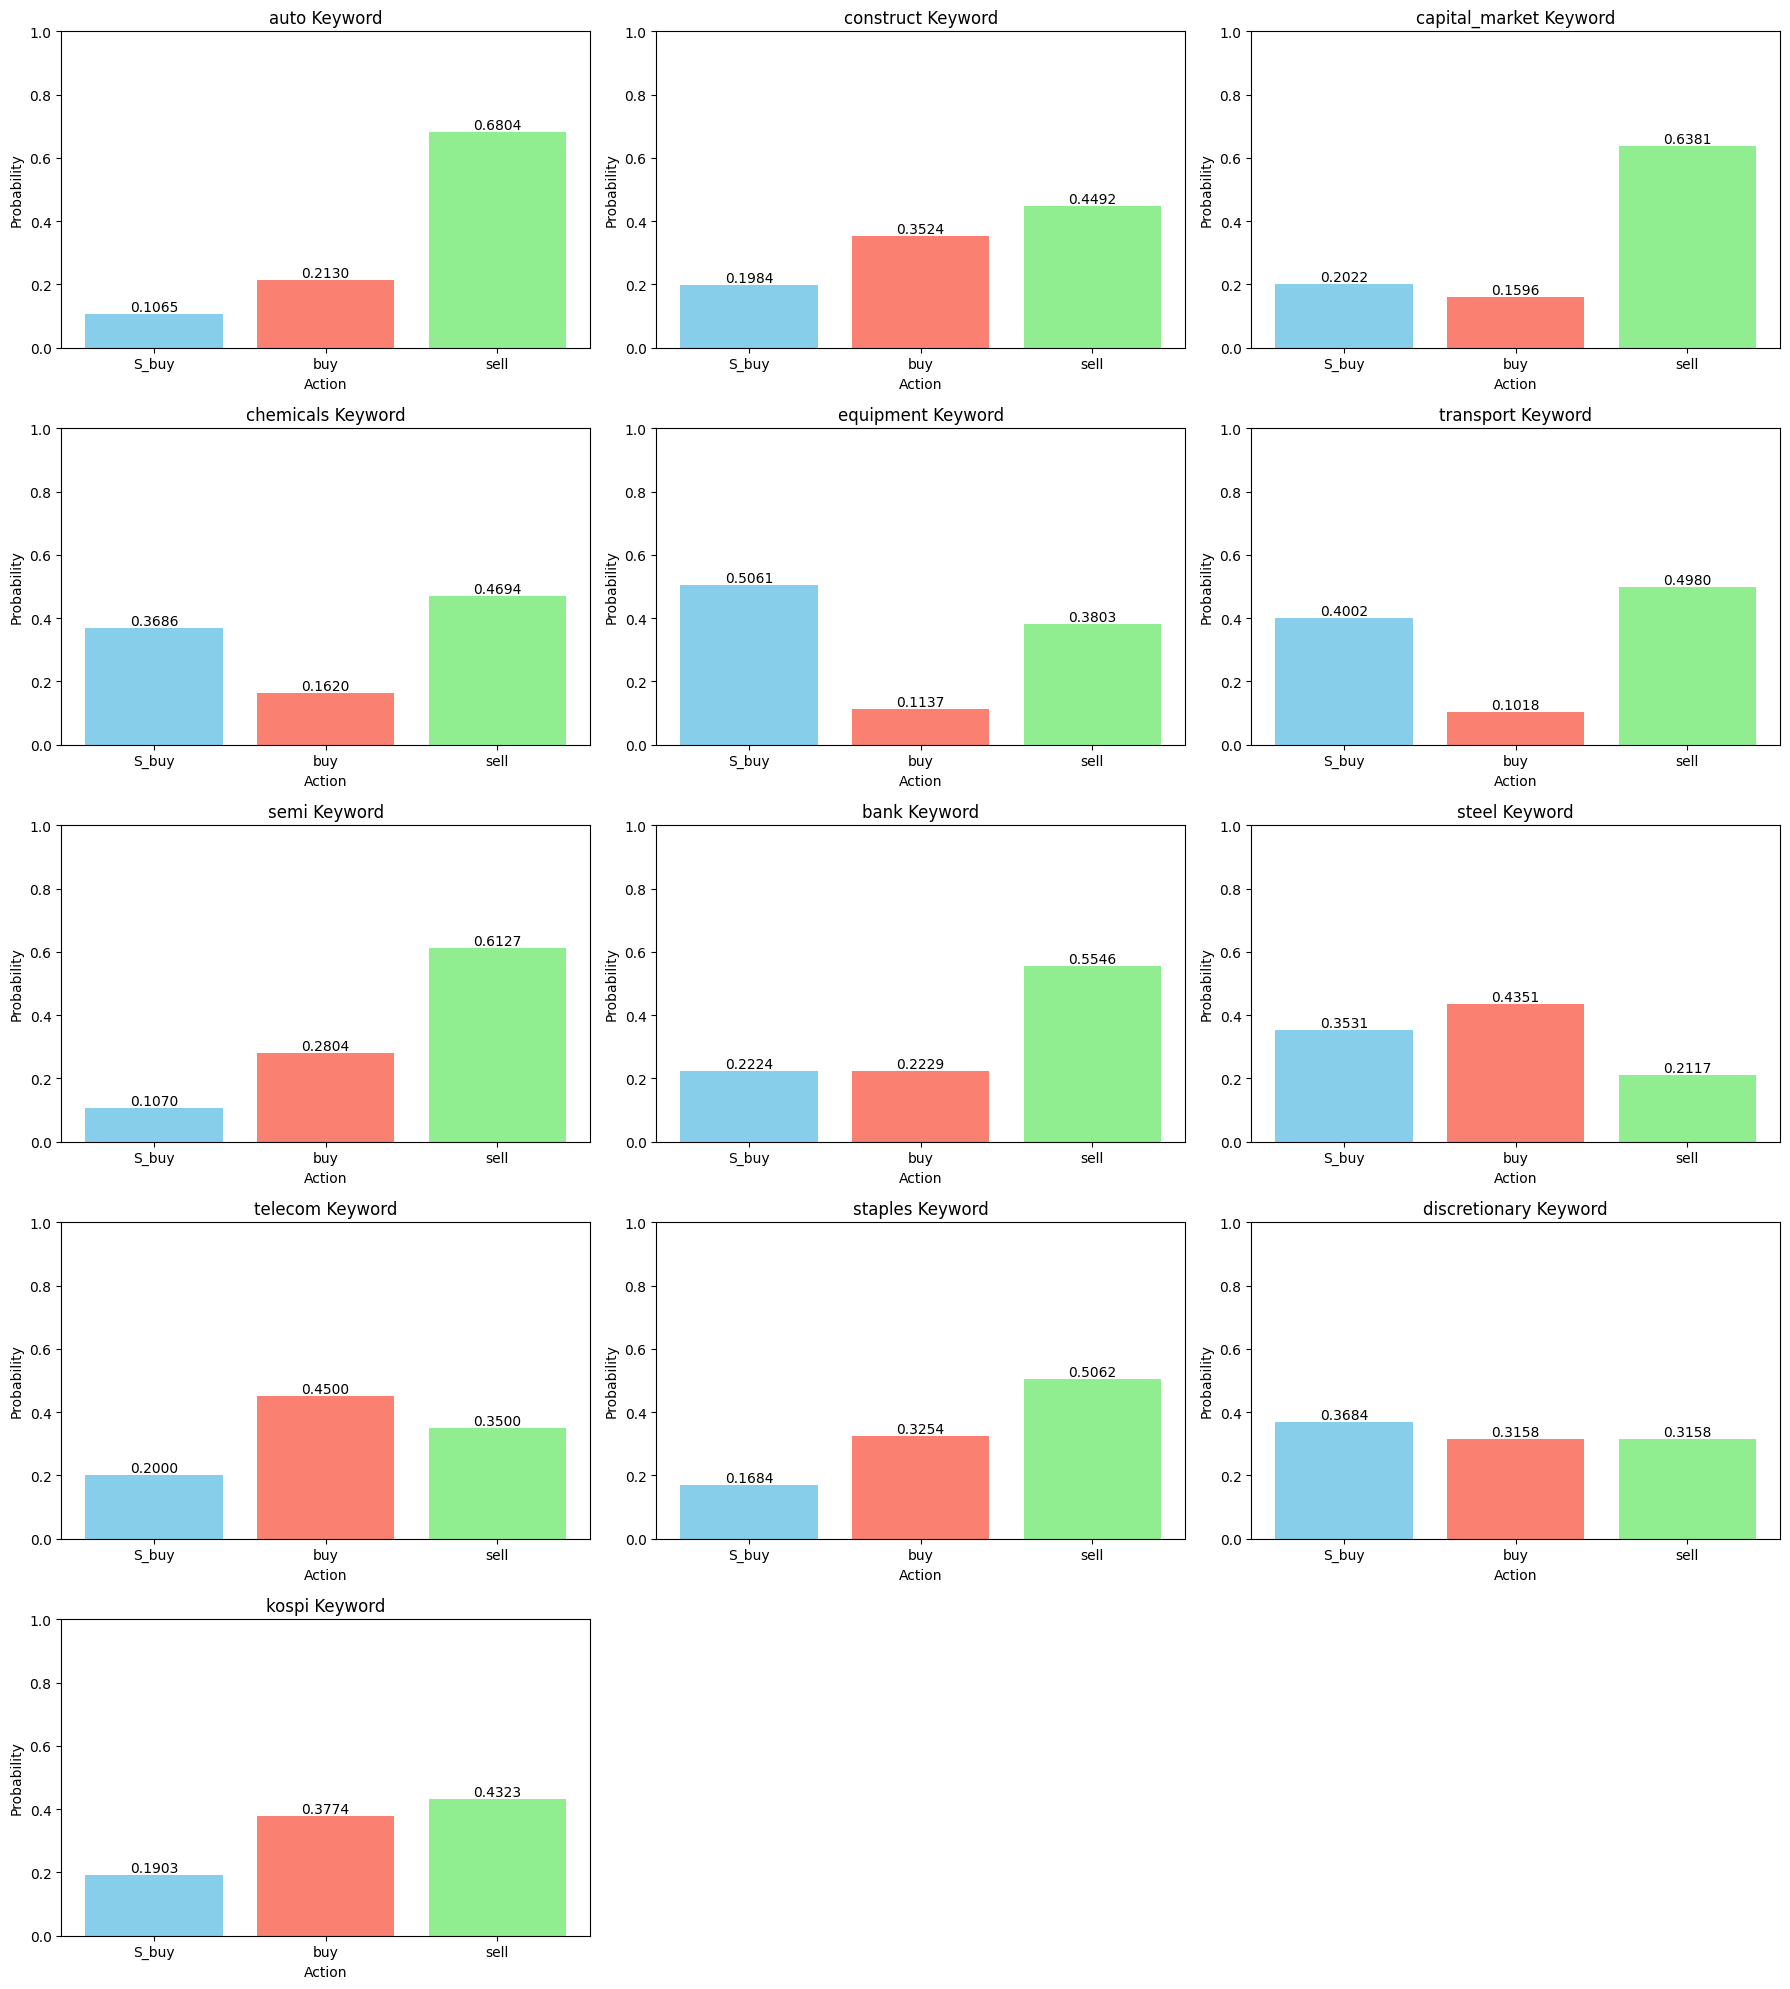

In [34]:
for keyword in keywords:
    filename = f"plk_folder_05/{keyword}_model.pkl"
    if os.path.exists(filename):
        loaded_models[keyword] = load(filename)
        print(f"Model for {keyword} keyword loaded from {filename}")
    else:
        print(f"Model file for {keyword} keyword does not exist: {filename}")

print("\n< AI model: load >")

# Predict probabilities for the last rows
probabilities = {}
for keyword, model in loaded_models.items():
    X_test_last_row_keyword = last_rows[keyword].values.reshape(1, -1)
    X_test_last_row_keyword = X_test_last_row_keyword[:, 1:]
    prob_current = model.predict_proba(X_test_last_row_keyword)
    probabilities[keyword] = {'S_buy': prob_current[0][0], 'buy': prob_current[0][1], 'sell': prob_current[0][2]}

# Print results
for keyword, probs in probabilities.items():
    print(keyword)
    for action, prob in probs.items():
        print(f'{action}: {prob:.4f}')
    print()

# Plot results
num_keywords = len(probabilities)
num_rows = (num_keywords + 2) // 3
num_cols = min(num_keywords, 3)
plt.figure(figsize=(6 * num_cols, 4 * num_rows))

for i, (keyword, probs) in enumerate(probabilities.items(), start=1):
    plt.subplot(num_rows, num_cols, i)
    plt.bar(probs.keys(), probs.values(), color=['skyblue', 'salmon', 'lightgreen'])
    plt.title(f'{keyword} Keyword')
    plt.xlabel('Action')
    plt.ylabel('Probability')
    plt.ylim(0, 1)
    for j, prob in enumerate(probs.values()):
        plt.text(j, prob, f'{prob:.4f}', ha='center', va='bottom')
        print(f'{keyword}')
        for action, prob in probs.items():
            print(f'{action}: {prob:.4f}')
        print()
plt.tight_layout()
plt.show()

In [30]:
import os
import numpy as np
import pandas as pd
from joblib import load
from sklearn.preprocessing import StandardScaler

# 백테스트 데이터 로드
backtesting_path = 'backtesting_raw_0702.xlsx'
backtesting_data = pd.read_excel(backtesting_path, sheet_name=None)

# 인덱스를 날짜 형식으로 변환 후 문자열로 변경
for keyword, df in backtesting_data.items():
    df.reset_index(drop=True, inplace=True)
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['date'] = df['date'].dt.strftime('%Y-%m-%d')
    df.set_index('date', inplace=True)
    print(f"{keyword} 키워드의 백테스트 데이터:")
    print(df.head())

auto 키워드의 백테스트 데이터:
              WTI  DGS2  DGS10  TIPS    VIX    PPI    per   pbr     원달러  \
date                                                                      
2010-05-03  86.19  1.00   3.72  1.32  20.19  173.9  15.23  1.26  1118.6   
2010-06-01  72.70  0.78   3.29  1.32  35.54  175.2  14.75  1.21  1216.5   
2010-07-01  72.95  0.63   2.96  1.21  32.86  176.1  15.06  1.25  1228.7   
2010-08-02  81.25  0.56   2.99  1.13  22.01  174.8  15.23  1.31  1172.5   
2010-09-01  73.97  0.50   2.58  1.02  23.89  174.7  15.13  1.29  1184.7   

                 원엔  ...   구리선물_60  중국고정자산투자(yoy%)_60  중국 PMI_60   금 선물_60  \
date                 ...                                                     
2010-05-03  1189.62  ...  0.002319          -0.002954  -0.000025  0.001183   
2010-06-01  1334.47  ... -0.002042          -0.000427   0.001456  0.001863   
2010-07-01  1391.03  ... -0.004316          -0.000458  -0.000573  0.001617   
2010-08-02  1354.71  ... -0.000225          -0.000569  -0.001476

In [35]:
# 저장된 모델 로드
model_dir = "plk_folder_05"
loaded_models = {}
for keyword in backtesting_data.keys():
    model_path = os.path.join(model_dir, f"{keyword}_model.pkl")
    if os.path.exists(model_path):
        loaded_models[keyword] = load(model_path)
        print(f"{keyword} 키워드의 모델을 {model_path}에서 로드했습니다.")
    else:
        print(f"{keyword} 키워드의 모델 파일이 {model_path}에 존재하지 않습니다.")

auto 키워드의 모델을 plk_folder_05\auto_model.pkl에서 로드했습니다.
construct 키워드의 모델을 plk_folder_05\construct_model.pkl에서 로드했습니다.
capital_market 키워드의 모델을 plk_folder_05\capital_market_model.pkl에서 로드했습니다.
chemicals 키워드의 모델을 plk_folder_05\chemicals_model.pkl에서 로드했습니다.
equipment 키워드의 모델을 plk_folder_05\equipment_model.pkl에서 로드했습니다.
transport 키워드의 모델을 plk_folder_05\transport_model.pkl에서 로드했습니다.
semi 키워드의 모델을 plk_folder_05\semi_model.pkl에서 로드했습니다.
bank 키워드의 모델을 plk_folder_05\bank_model.pkl에서 로드했습니다.
steel 키워드의 모델을 plk_folder_05\steel_model.pkl에서 로드했습니다.
telecom 키워드의 모델을 plk_folder_05\telecom_model.pkl에서 로드했습니다.
staples 키워드의 모델을 plk_folder_05\staples_model.pkl에서 로드했습니다.
discretionary 키워드의 모델을 plk_folder_05\discretionary_model.pkl에서 로드했습니다.
kospi 키워드의 모델을 plk_folder_05\kospi_model.pkl에서 로드했습니다.


In [36]:
# 각 모델의 예측이 특정 패턴을 따르는 경우, 예측 결과가 동일하게 나타날 수 있습니다.
#예를 들어, 모델이 특정한 임계값을 기준으로 예측을 수행하는 경우, 입력 데이터가 그 임계값을 넘지 않는다면 결과는 동일할 수 있습니다.
# 즉 우리가 수행한 모델이 일정 값을 넘기면 S_buy buy sell이므로 오류가 생겼던 것 같ㅇ므
from sklearn.preprocessing import StandardScaler

# 각 행에 대해 예측 수행
all_predictions = {}

for keyword, df in backtesting_data.items():
    if keyword in loaded_models:
        model = loaded_models[keyword]
        predictions = []
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(df)
        for idx, row in enumerate(df_scaled):
            date = df.index[idx]  # 인덱스가 날짜 형식임
            X_test = row.reshape(1, -1)
            probabilities = model.predict_proba(X_test)[0]
            predictions.append({
                'date': date,
                'S_buy': probabilities[0],
                'buy': probabilities[1],
                'sell': probabilities[2]
            })
        all_predictions[keyword] = pd.DataFrame(predictions)
        print(f"\n{keyword} 키워드의 예측 결과:")
        print(all_predictions[keyword].head())


auto 키워드의 예측 결과:
         date     S_buy       buy      sell
0  2010-05-03  0.892379  0.107621  0.000000
1  2010-06-01  0.159710  0.370177  0.470114
2  2010-07-01  0.263158  0.473684  0.263158
3  2010-08-02  0.367211  0.053958  0.578831
4  2010-09-01  0.943837  0.053826  0.002338

construct 키워드의 예측 결과:
         date     S_buy       buy      sell
0  2010-05-03  0.098148  0.151852  0.750000
1  2010-06-01  0.300000  0.550000  0.150000
2  2010-07-01  0.300000  0.647686  0.052314
3  2010-08-02  0.250000  0.500000  0.250000
4  2010-09-01  0.996242  0.003033  0.000725

capital_market 키워드의 예측 결과:
         date     S_buy       buy      sell
0  2010-05-03  0.110974  0.116914  0.772112
1  2010-06-01  0.150000  0.750000  0.100000
2  2010-07-01  0.893035  0.106965  0.000000
3  2010-08-02  0.054427  0.155482  0.790091
4  2010-09-01  0.943569  0.055450  0.000980

chemicals 키워드의 예측 결과:
         date     S_buy       buy      sell
0  2010-05-03  0.052860  0.159352  0.787787
1  2010-06-01  0.947368  0.0

In [37]:
# 예측 결과를 엑셀 파일로 저장
output_path = "predictions_v5sdfsd.xlsx"
with pd.ExcelWriter(output_path) as writer:
    for keyword, predictions_df in all_predictions.items():
        predictions_df.to_excel(writer, sheet_name=keyword, index=False)
print(f"예측 결과가 {output_path}에 저장되었습니다.")

예측 결과가 predictions_v5sdfsd.xlsx에 저장되었습니다.
